数据来源(Source)：http://insideairbnb.com/ #Shanghai
截取日期：June 21, 2022

Step 0: 导入库(Import libraries)

In [95]:
#数据框架
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.set_option('display.max_columns', None)

#图像化
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import ticker
from pylab import mpl
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False
import seaborn as sb
import plotly.express as px

#文字分析
import jieba
from wordcloud import WordCloud,STOPWORDS

#SQL
import mysql.connector as mysql
from getpass import getpass
connection = mysql.connect(
  host ="localhost",
  user ='root',
  passwd ="mysqlmima",
  database = "airbnb_shanghai"
)
cursorobject = connection.cursor()

In [9]:
# Word cloud 图像生成公式
def wordcloud(comment_column):
    comments = comment_column.astype('string')
    full_txt = " ".join(comment 
                    for comment in comments 
                    if not(pd.isnull(comment)) == True)
    word_list = jieba.cut(full_txt)
    final = " ".join(word_list)
    font = r'C:\Windows\Fonts\simhei.ttf'
    stopwords = set(STOPWORDS)
    stopwords.update(["很", "的", "也", "好的", "都很",'非常好','去','是','真的','br',
                      '是在','Airbnb','非常棒','特别好','特别','小姐姐','真的是','挺好',
                      '好','都','有','来','时候','就在','非常','因为','不是','我','上海',
                      '在','Shanghai','b','号线','左右','可','note','更多','让您','为您',
                      '很多','如果','你','您','Website hidden','希望','能','这里','为',
                      '过','thing','Guest access'])
    wordcloud = WordCloud(stopwords=stopwords,font_path = font,
                          width=1600,height=900,margin=2).generate(final)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

已跳过：数据导入、清理和概述(Data Cleaning) # Switched to SQL in a separate script  
review = pd.read_csv('reviews.csv', 
                     parse_dates= [2],
                     dtype= {'listing_id':'int64','reviewer_id':'int64'})
review.set_index('id',inplace=True)
review.drop(columns=['reviewer_name'],inplace=True)
listings = pd.read_csv('listings.csv', encoding_errors= 'ignore',encoding='utf-8')
listings.head()
listings[listings['first_review'] == '0000-00-00']
listings = pd.read_csv('listings.csv', encoding_errors= 'ignore',encoding='utf-8')
listings.set_index('id', inplace= True)

-去除无意义的数据
listings.drop(columns=['scrape_id','last_scraped','calendar_last_scraped','calendar_updated',
                       'picture_url','listing_url','host_url','host_picture_url','host_thumbnail_url',
                       'bathrooms','license','number_of_reviews_l30d','neighbourhood','neighbourhood_group_cleansed',
                       'minimum_nights', 'maximum_nights',  'minimum_minimum_nights', 'maximum_minimum_nights', 
                       'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                       'has_availability','availability_30','availability_60','availability_90'],inplace=True)
indexNames_drop = listings[(listings['host_neighbourhood'] == 'Tsim Sha Tsui') & 
                           (listings['host_neighbourhood'] == 'Chaoyang Park/Tuan Jie Hu') &
                           (listings['host_neighbourhood'] == 'Wuyi Shangquan') &
                           (listings['host_neighbourhood'] == 'Eisenhower East') &
                           (listings['host_neighbourhood'] == 'Wanyuan City/East Portland Road')].index
listings.drop(indexNames_drop , inplace=True)


-Drop NaN
listings.dropna(subset=['name'], inplace = True)
listings.dropna(subset=['host_has_profile_pic'], inplace = True)
listings.dropna(subset=['host_identity_verified'], inplace = True)
listings.dropna(subset=['host_name'], inplace = True)

-去除价格为零的行
listings = listings[listings['price'] != 0]

-去重
listings.drop_duplicates(['name'],inplace=True)

-转换object为数字
listings['price'] = listings['price'].apply(lambda x: x.replace('$','').replace(',','')).astype('float')
listings['host_response_rate'] = listings['host_response_rate'].str.replace(r"\D","",regex=True)
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'])
listings['host_response_rate'] = listings['host_response_rate']/100
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.replace(r"\D","",regex=True)
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'])
listings['host_acceptance_rate'] = listings['host_acceptance_rate']/100

-设定object为日期
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['last_review'] = pd.to_datetime(listings['last_review'])

-转换逻辑列为True/False
listings['instant_bookable'] = np.where(listings['instant_bookable'] == 't', True, False)
listings['host_is_superhost'] = np.where(listings['host_is_superhost'] == 't', True, False)

-设定类别列
listings['host_neighbourhood'].replace({'Xintiandi':'新天地', 'Conservatory':'音乐学院', 'Putuo':'普陀', 'Quyang':'曲阳', None:'', 'Pudong':'浦东',
                                        'Hongkou':'虹口', 'Caojiadu':'曹家渡', 'Nanjing Road West':'南京西路', 'Zhongshan Park':'中山公园',
                                        'Songjiang':'松江', 'Xinhua Road':'新华路', 'Hengshan':'衡山', 'Jinqiao':'金桥', 'Huangpu':'黄埔', 
                                        'Xuhui':'徐汇', 'Baoshan':'宝山', 'Qingpu':'青浦', "Jing'an":'静安', 'Changning':'长宁', 'Lu Jia Zui':'陆家嘴', 
                                        'Luwan':'黄埔', 'Temple':'城隍庙', 'Cypress':'龙柏新村', 'Changshou Road':'常熟路', 'Yangpu':'杨浦', 
                                        'Zhabei':'闸北', 'Chunshen':'春申', 'Tongle Fang':'同乐坊', 'Gubei':'古北', 'Jiading':'嘉定', 
                                        "People's Square":'人民广场', 'Dapuqiao':'打浦桥', 
                                        'Meichuan Road':'梅川路', 'Xujiahui':'徐家汇', 'Fengxian':'奉贤', 'Hongmei Road':'虹梅路', 'Minhang':'闵行',
                                        'Longhua':'龙华', 'Xinjiekou':'新街口', 'Weifang New Village':'潍坊新村', 
                                        'Old Minhang':'闵行', 'Lujiazui':'陆家嘴', 'Hongqiao':'虹桥', 'Tangqiao':'塘桥', 'Zhenru':'真如',
                                        "Jing'an Temple":'静安寺', 'Dongjiadu':'董家渡', 'Ren Min Guang Chang':'人民广场',
                                        'Jinshan':'金山', 'Nanfang Shangcheng':'南方商城', 'Changfeng Park':'长风公园', 'Pujiang Town':'浦江镇',
                                        'Haining Road':'海宁路', 'Pengpuxincun':'彭浦新村', 'Huǒchē':'', 'Waigaoqiao':'外高桥', 
                                        'Linyi New Village':'临沂新村', 'Hongqiao Town':'虹桥', 'Chuansha':'川沙', 'Jing An Si':'静安寺',
                                        'Huo Che Zhan':'上海火车站', 'Hong Qiao':'虹桥', 'Shi Ji Gong Yuan':'世纪公园', 'Chuan Sha':'川沙', 'Xin Zhuang':'莘庄', 
                                        'Huai Hai Lu Dong Duan':'淮海东路', 'Wai Tan':'外滩', 'Da Pu Qiao':'打浦桥', 'Wan Ti Guan':'万体馆', 
                                        'Nanjing West Road':'南京西路', 'Xu Jia Hui':'徐家汇', 'Wu Ke Song':'五棵松', 'Zhong Shan Bei Lu':'中山北路', 
                                        'Si Chuan Bei Lu':'四川北路', 'Nan Jing Dong Lu':'南京东路', 'Waitan':'外滩','Bang Kapi':'嘉定','Yaohan':'陆家嘴','Lower Sukhumvit':'外滩',
                                        'Wu Yi Shang Quan':'宝山','Østerbro':'静安','Watertown':'闵行','Southern Region':'','Soho':'静安','Shek Kip Mei':'世纪公园',
                                        'North Lake Waco':'川沙','Old Simon':'老西门','Fortress Hill':'','Klong Toey':'外滩','Caohejing/TianLin':'漕河泾',
                                        "St John's Wood":'外滩','Palmera-Bellavista':'人民广场','Xiang Gang Lu Can Yin Jie':'崇明','Corey Hill':'音乐学院',
                                        'East Village':'崇明','Pinklao':'临港新城','新槎浦':''})

-Fill NaN with blank or 0
listings['reviews_per_month'].fillna(0, inplace = True) 
listings['host_neighbourhood'].fillna('', inplace = True)
listings['description'].fillna('', inplace = True)
listings['host_location'].fillna('', inplace = True)
listings['neighborhood_overview'].fillna('', inplace = True)
listings['host_response_time'].fillna('', inplace = True)

-Fill NaN with mean
listings['review_scores_rating'].fillna(listings['review_scores_rating'].median(), inplace = True) 
listings['review_scores_accuracy'].fillna(listings['review_scores_accuracy'].median(), inplace = True) 
listings['review_scores_cleanliness'].fillna(listings['review_scores_cleanliness'].median(), inplace = True) 
listings['review_scores_checkin'].fillna(listings['review_scores_checkin'].median(), inplace = True) 
listings['review_scores_communication'].fillna(listings['review_scores_communication'].median(), inplace = True) 
listings['review_scores_location'].fillna(listings['review_scores_location'].median(), inplace = True) 
listings['review_scores_value'].fillna(listings['review_scores_value'].median(), inplace = True) 

Step 1：变量特征(Features)

In [10]:
cursorObject = connection.cursor()
cursorObject.execute("SELECT * FROM listings")
listings = pd.DataFrame(cursorObject.fetchall(), columns=['id','listing_url','name','description','neighbourhood_overview',
                                                          'picture_url','host_id','host_url','host_name','host_since','host_location',
                                                          'host_about','host_response_time','host_response_rate','host_acceptance_rate',
                                                          'host_is_superhost','host_thumbnail_url','host_picture_url','host_neighbourhood',
                                                          'host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic',
                                                          'host_identity_verified','neighbourhood','neighbourhood_cleansed','latitude','longitude','property_type',
                                                          'room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights',
                                                          'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                                                          'maximum_nights_avg_ntm','has_availability','availability_30','availability_60','availability_90','availability_365','number_of_reviews',
                                                          'number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','review_scores_rating','review_scores_accuracy',
                                                          'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
                                                          'instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                                                          'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month'])
listings.head(1)

id                         listing_url  \
0  24963  https://www.airbnb.com/rooms/24963   

                                              name  \
0  Heart of French Built Music Conservatory / Home   

                                         description  \
0  The flat is located in the heart of formal Fre...   

                              neighbourhood_overview  \
0  It's Shanghai Music Concession adjacent, lots ...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/560599/168338...    98203   

                                  host_url host_name  host_since  \
0  https://www.airbnb.com/users/show/98203       Jia  2010-03-24   

               host_location  \
0  Shanghai, Shanghai, China   

                                          host_about host_response_time  \
0  I am an architect, trained and studied in US, ...                N/A   

  host_response_rate host_acceptance_rate  host_is_superhost  \
0               None                 None                  0   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/user/d3af0...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/d3af0...               音乐学院   

   host_listings_count  host_total_listings_count  host_verifications  \
0                    2                          2  ['email', 'phone']   

   host_has_profile_pic  host_identity_verified    neighbourhood  \
0                     1                       1  Shanghai, China   

  neighbourhood_cleansed  latitude  longitude       property_type  \
0   徐汇区 / Xuhui District   31.2107    121.452  Entire rental unit   

         room_type  accommodates bathrooms_text  bedrooms  beds  \
0  Entire home/apt             3         1 bath         1     2   

                                           amenities  price  minimum_nights  \
0  ["Oven", "Heating", "Building staff", "Dishes ...    480               3   

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0             365                       3                       3   

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                     365                     365                       3   

   maximum_nights_avg_ntm  has_availability  availability_30  availability_60  \
0                     365                 1                6               13   

   availability_90  availability_365  number_of_reviews  \
0               13                13                 85   

   number_of_reviews_ltm  number_of_reviews_l30d first_review last_review  \
0                      0                       0   2010-09-26  2020-08-15   

  review_scores_rating review_scores_accuracy review_scores_cleanliness  \
0                 4.74                   4.87                      4.54   

  review_scores_checkin review_scores_communication review_scores_location  \
0                  4.77                        4.70                   4.86   

  review_scores_value  instant_bookable  calculated_host_listings_count  \
0                4.76                 0                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   

   calculated_host_listings_count_private_rooms  \
0                                             0   

   calculated_host_listings_count_shared_rooms reviews_per_month  
0                                            0              0.59

In [11]:
listings.shape

(20352, 67)

In [12]:
listings.shape

(20352, 67)

In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20352 entries, 0 to 20351
Data columns (total 67 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20352 non-null  int64  
 1   listing_url                                   20352 non-null  object 
 2   name                                          20352 non-null  object 
 3   description                                   20352 non-null  object 
 4   neighbourhood_overview                        20352 non-null  object 
 5   picture_url                                   20352 non-null  object 
 6   host_id                                       20352 non-null  int64  
 7   host_url                                      20352 non-null  object 
 8   host_name                                     20352 non-null  object 
 9   host_since                                    20351 non-null 

In [14]:
listings.describe()

id       host_id  host_is_superhost  host_listings_count  \
count  2.035200e+04  2.035200e+04       20352.000000         20352.000000   
mean   4.033484e+07  2.160995e+08           0.323408            14.992237   
std    1.834884e+07  1.197060e+08           0.467788            37.667610   
min    2.496300e+04  9.820300e+04           0.000000             0.000000   
25%    3.411125e+07  1.155242e+08           0.000000             1.000000   
50%    4.333619e+07  2.174069e+08           0.000000             6.000000   
75%    4.906710e+07  3.115373e+08           1.000000            15.000000   
max    2.147484e+09  4.415789e+08           1.000000           974.000000   

       host_total_listings_count  host_has_profile_pic  \
count               20352.000000          20352.000000   
mean                   14.992237              0.999066   
std                    37.667610              0.030541   
min                     0.000000              0.000000   
25%                     1.000000              1.000000   
50%                     6.000000              1.000000   
75%                    15.000000              1.000000   
max                   974.000000              1.000000   

       host_identity_verified      latitude     longitude  accommodates  \
count            20352.000000  20352.000000  20352.000000  20352.000000   
mean                 0.999214     31.206111    121.505764      4.066775   
std                  0.028028      0.142383      0.173896      3.742224   
min                  0.000000     30.711100    120.859000      1.000000   
25%                  1.000000     31.136400    121.432000      2.000000   
50%                  1.000000     31.200800    121.484000      2.000000   
75%                  1.000000     31.235200    121.658000      4.000000   
max                  1.000000     31.827000    121.942000     16.000000   

           bedrooms          beds          price  minimum_nights  \
count  20352.000000  20352.000000   20352.000000    20352.000000   
mean       1.900649      2.478823    1025.886399        6.970371   
std        2.049689      3.033423    3032.885597       34.439238   
min        1.000000      0.000000      23.000000        1.000000   
25%        1.000000      1.000000     269.000000        1.000000   
50%        1.000000      1.000000     400.000000        1.000000   
75%        2.000000      2.000000     699.000000        1.000000   
max       50.000000     50.000000  150000.000000     1000.000000   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
count    20352.000000            20352.000000            20352.000000   
mean       871.211969                6.859228                7.018524   
std        420.552115               34.202816               34.656752   
min          1.000000                1.000000                1.000000   
25%        365.000000                1.000000                1.000000   
50%       1125.000000                1.000000                1.000000   
75%       1125.000000                1.000000                1.000000   
max       1128.000000             1000.000000             1000.000000   

       minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
count            20352.000000            20352.000000            20352.000000   
mean               937.873624              938.473074                6.936321   
std                375.086778              374.569165               34.389012   
min                  1.000000                1.000000                1.000000   
25%               1125.000000             1125.000000                1.000000   
50%               1125.000000             1125.000000                1.000000   
75%               1125.000000             1125.000000                1.000000   
max               1128.000000             1128.000000             1000.000000   

       maximum_nights_avg_ntm  has_availability  availability_30  \
count             20352.00000      20352.000000     203

In [15]:
listings.nunique()

id                                              20352
listing_url                                     20352
name                                            20352
description                                     20352
neighbourhood_overview                          13557
picture_url                                     19983
host_id                                          6768
host_url                                         6768
host_name                                        5046
host_since                                       2498
host_location                                     160
host_about                                       3562
host_response_time                                  6
host_response_rate                                  2
host_acceptance_rate                               68
host_is_superhost                                   2
host_thumbnail_url                               6754
host_picture_url                                 6754
host_neighbourhood          

In [30]:
cursorObject = connection.cursor()
cursorObject.execute('''
    SELECT *
    FROM listing_text''')
listing_text = pd.DataFrame(cursorObject.fetchall(),
                                columns=['id', 'name', 'description', 'neighbourhood_overview'])
listing_text.head()

id                                               name  \
0   24963    Heart of French Built Music Conservatory / Home   
1  479517                 有简约 绿色系 功能齐全 高楼层的绿色舒适7/13双轨交阳光暖窝公寓   
2  479530      【sidihome】ROSE  the big space apt in downtown   
3  496972          Modern Stylish Master Bedroom  near metro   
4  519944  Shared, Puxiong Rd, 10 min taxi to Jing'an Temple   

                                         description  \
0  The flat is located in the heart of formal Fre...   
1  绿色系的房间，化繁为简，通过房间简单的元素的搭配，合理的空间布局，全新的装修配置，塑造一个通...   
2  [SidiHome, The Nordic style] The background of...   
3  Hello world! I'm very excited to welcome you t...   
4  Great location, a 10 minute taxi ride to Jing'...   

                              neighbourhood_overview  
0  It's Shanghai Music Concession adjacent, lots ...  
1  市中心,江宁路,靠近新会路,距离地铁站也很近。著名的玉佛寺就在一街之隔,大卖场,便利店,购物...  
2  Central location, easy to get subway station l...  
3  This  beautiful and clean area in Shanghai is ...  
4  shops, restaurants and malls within a 10 minut...

Step 1.1: Features: listing availability

Text(0.5, 0, '出租时长')

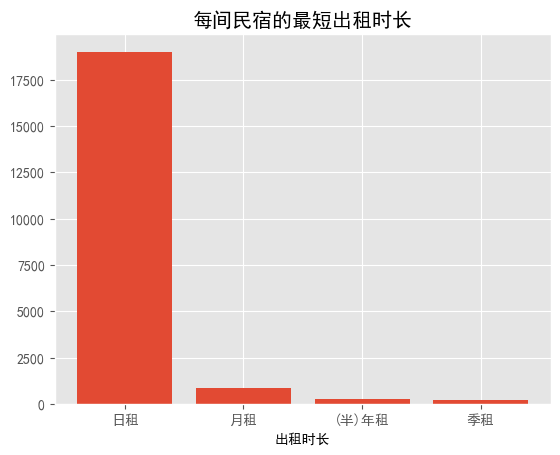

In [16]:
cursorObject = connection.cursor()
cursorObject.execute('''
    SELECT CASE 
        WHEN la.minimum_nights_avg_ntm < 20 THEN '日租'
        WHEN la.minimum_nights_avg_ntm >= 20 AND la.minimum_nights_avg_ntm <= 40 THEN '月租'
        WHEN la.minimum_nights_avg_ntm > 40  AND la.minimum_nights_avg_ntm <= 100 THEN '季租'
        WHEN la.minimum_nights_avg_ntm > 100 THEN '(半)年租'
        END leasing_period, COUNT(*)
    FROM listing_availability la
    GROUP BY leasing_period''')
leasing_period = pd.DataFrame(cursorObject.fetchall(),columns=['Type','Count'])
leasing_period.head()

fig,ax = plt.subplots()
ax.bar(leasing_period['Type'],leasing_period['Count'])
ax.set_title('每间民宿的最短出租时长')
ax.set_xlabel('出租时长')

Step 1.2: Features: listing properties

In [17]:
cursorObject = connection.cursor()
cursorObject.execute('''
    SELECT *
    FROM listing_property''')
listing_property = pd.DataFrame(cursorObject.fetchall(),
                                columns=['id','neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude',
                                         'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds','amenities', 'price'])
listing_property.head()


id    neighbourhood  neighbourhood_cleansed  latitude  longitude  \
0   24963  Shanghai, China    徐汇区 / Xuhui District   31.2107    121.452   
1  479517  Shanghai, China  静安区 / Jing'an District   31.2431    121.444   
2  479530  Shanghai, China  静安区 / Jing'an District   31.2437    121.445   
3  496972  Shanghai, China  虹口区 / Hongkou District   31.2769    121.495   
4  519944  Shanghai, China    普陀区 / Putuo District   31.2381    121.416   

                 property_type        room_type  accommodates  \
0           Entire rental unit  Entire home/apt             3   
1           Entire rental unit  Entire home/apt             2   
2           Entire rental unit  Entire home/apt             3   
3  Private room in rental unit     Private room             2   
4  Private room in rental unit     Private room             1   

     bathrooms_text  bedrooms  beds  \
0            1 bath         1     2   
1            1 bath         1     1   
2            1 bath         1     2   
3  1.5 shared baths         1     1   
4     1 shared bath         1     1   

                                           amenities  price  
0  ["Oven", "Heating", "Building staff", "Dishes ...    480  
1  ["Hair dryer", "Iron", "Bathroom essentials", ...    458  
2  ["Paid parking on premises", "Dishes and silve...    437  
3  ["Heating", "Dishes and silverware", "Cable TV...    135  
4  ["Paid parking on premises", "Oven", "Heating"...    280

In [19]:
fig = px.density_mapbox(listing_property,lat='latitude',lon='longitude',radius=1,
                        center=dict(lat=31.28,lon=121.5),zoom=7.2,
                        mapbox_style = 'stamen-terrain')
fig.show()

In [20]:
fig = px.density_mapbox(listing_property,lat='latitude',lon='longitude',radius=2,
                        center=dict(lat=31.13,lon=121.69),zoom=11,
                        mapbox_style = 'stamen-terrain')
fig.show()

In [21]:
fig = px.density_mapbox(listing_property,lat='latitude',lon='longitude',radius=2,
                        center=dict(lat=31.22,lon=121.46),zoom=11,
                        mapbox_style = 'stamen-terrain')
fig.show()

Text(0.5, 0, '出租范围')

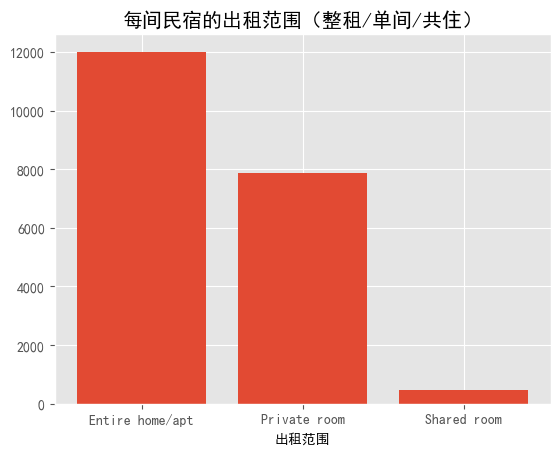

In [22]:
cursorObject = connection.cursor()
cursorObject.execute('''
    select distinct room_type, count(*) 
    from listing_property 
    group by room_type;''')
properties_room_type = pd.DataFrame(cursorObject.fetchall())

fig,ax = plt.subplots()
ax.bar(properties_room_type[0],properties_room_type[1])
ax.set_title('每间民宿的出租范围（整租/单间/共住）')
ax.set_xlabel('出租范围')

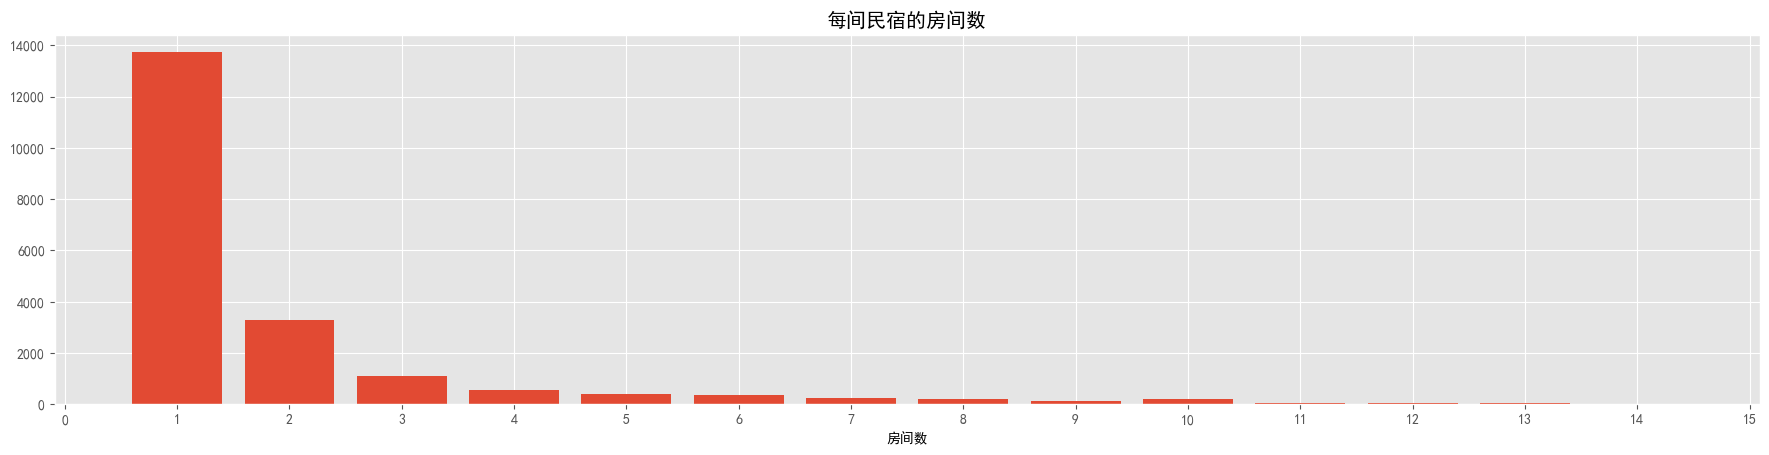

In [23]:
cursorObject = connection.cursor()
cursorObject.execute('''
    select distinct bedrooms, count(*) 
    from listing_property
    group by bedrooms;''')
properties_bedrooms = pd.DataFrame(cursorObject.fetchall())
properties_bedrooms_omit_extreme = properties_bedrooms[properties_bedrooms[0]<15]
fig,ax = plt.subplots()
ax.bar(properties_bedrooms_omit_extreme[0],properties_bedrooms_omit_extreme[1])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title('每间民宿的房间数')
ax.set_xlabel('房间数')
fig.set_figwidth(22)

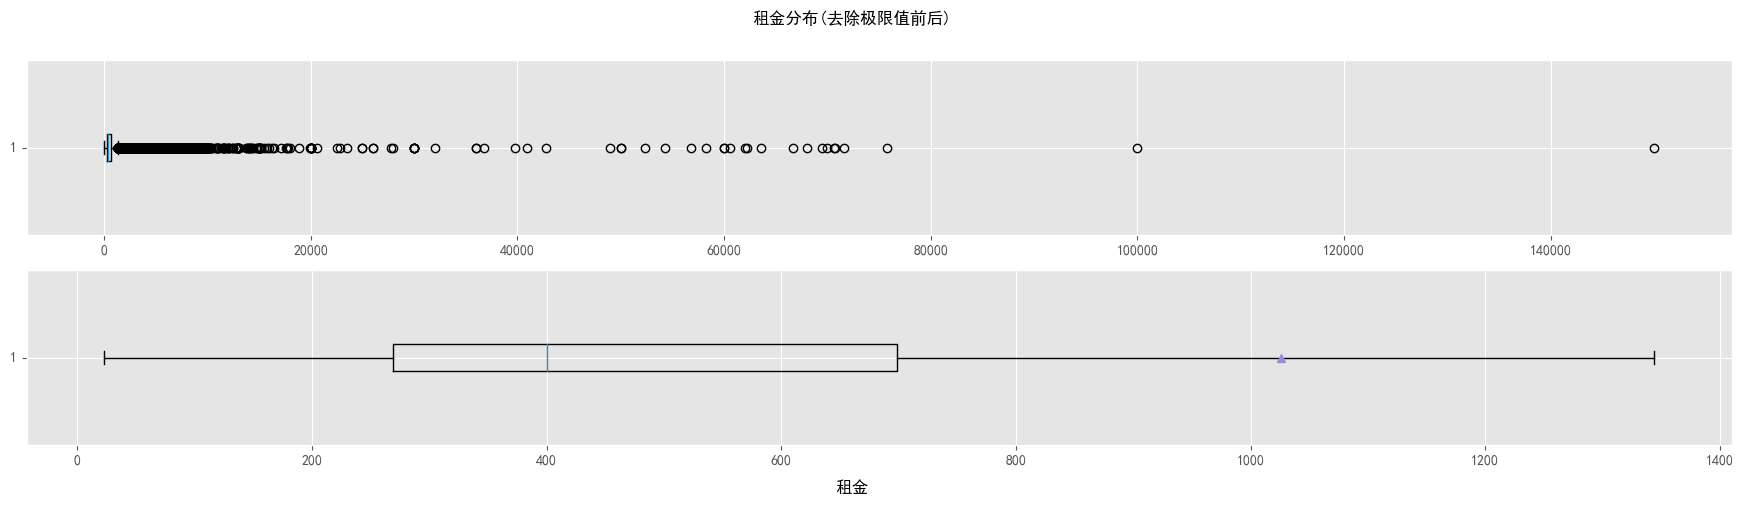

In [24]:
fig, axs = plt.subplots(2,1)
axs[0].boxplot(listing_property['price'],vert=False)
axs[1].boxplot(listing_property['price'],vert=False,showfliers=False,showmeans=True)
fig.suptitle('租金分布(去除极限值前后)')
fig.supxlabel('租金')
fig.set_figwidth(22)
fig.set_figheight(5)

从民宿的价格上看，整体呈左偏分布。上海Airbnb的均价约为925元，而中位数在388元。有一半的民宿价格在259到668之间。

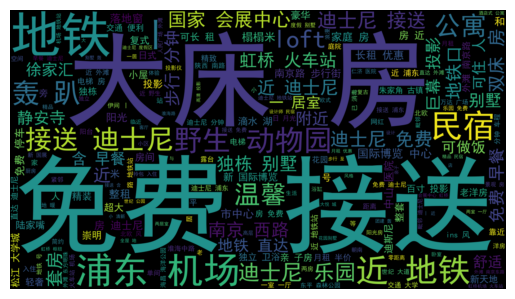

In [31]:
wordcloud(listing_text['name'])

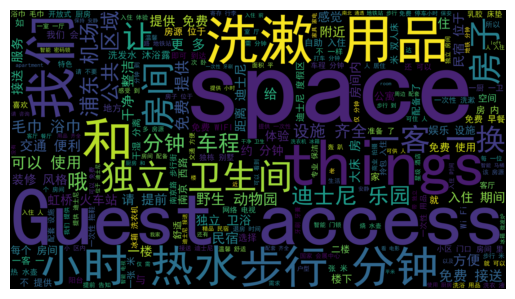

In [32]:
wordcloud(listing_text['description'])

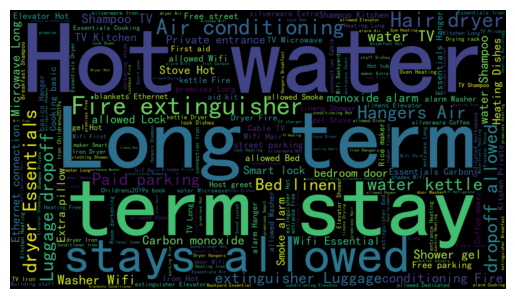

In [33]:
wordcloud(listing_property['amenities'])

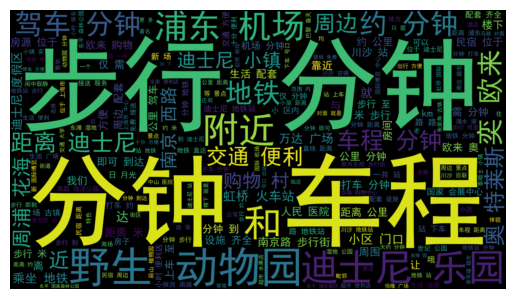

In [35]:
wordcloud(listing_text['neighbourhood_overview'])

Step 1.3: Features: listing reviews

In [36]:
cursorObject = connection.cursor()
cursorObject.execute('''
    SELECT *
    FROM listing_review''')
listing_review = pd.DataFrame(cursorObject.fetchall(),
                                columns=['id','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','review_scores_rating','review_scores_accuracy',
                                                          'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month'])
listing_review.head()

id  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0   24963                 85                      0                       0   
1  479517                 84                      9                       0   
2  479530                 46                      7                       0   
3  496972                 90                      6                       0   
4  519944                 22                      4                       0   

  first_review last_review review_scores_rating review_scores_accuracy  \
0   2010-09-26  2020-08-15                 4.74                   4.87   
1   2012-08-02  2022-02-12                 4.89                   4.86   
2   2012-08-25  2022-02-21                 4.89                   4.91   
3   2012-07-17  2022-01-26                 4.66                   4.64   
4   2012-08-18  2021-11-11                 4.90                   4.95   

  review_scores_cleanliness review_scores_checkin review_scores_communication  \
0                      4.54                  4.77                        4.70   
1                      4.68                  4.88                        4.95   
2                      4.84                  4.91                        4.95   
3                      4.45                  4.83                        4.81   
4                      5.00                  5.00                        4.95   

  review_scores_location review_scores_value reviews_per_month  
0                   4.86                4.76              0.59  
1                   4.87                4.78              0.70  
2                   4.86                4.86              0.38  
3                   4.58                4.62              0.74  
4                   4.82                4.86              0.18

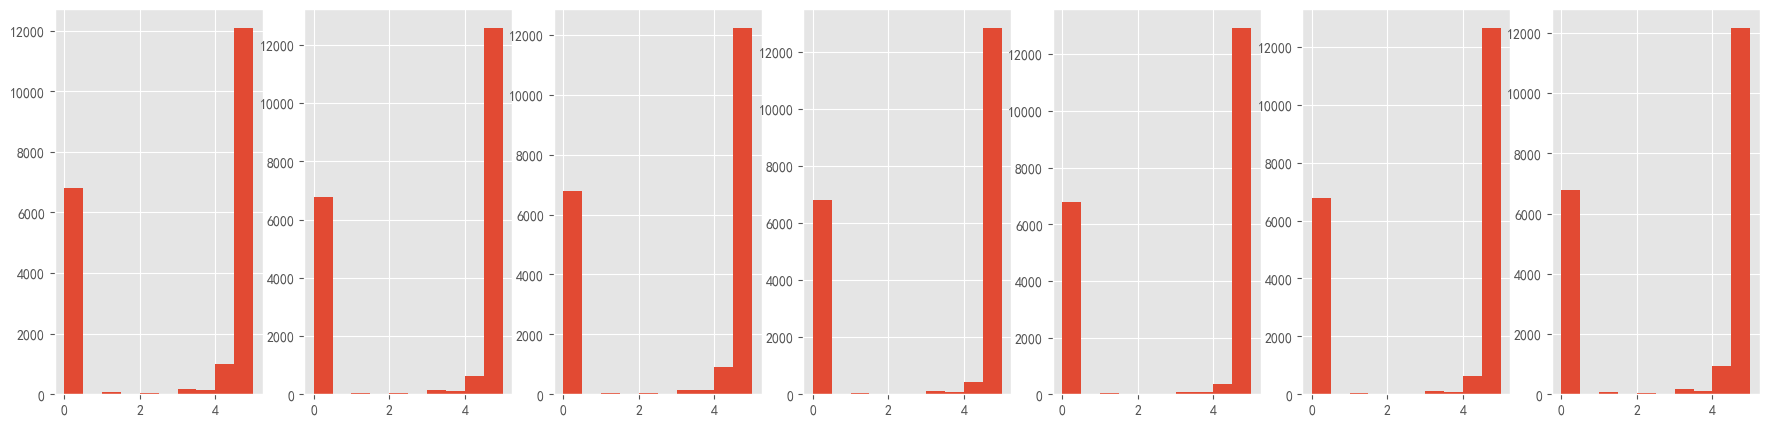

In [38]:
fig, axs = plt.subplots(1,7)
axs[0].hist(listings['review_scores_rating'])
axs[1].hist(listings['review_scores_accuracy'])
axs[2].hist(listings['review_scores_cleanliness'])
axs[3].hist(listings['review_scores_checkin'])
axs[4].hist(listings['review_scores_communication'])
axs[5].hist(listings['review_scores_location'])
axs[6].hist(listings['review_scores_value'])
fig.set_figwidth(22)
fig.set_figheight(5)

Text(0.5, 0, '天数')

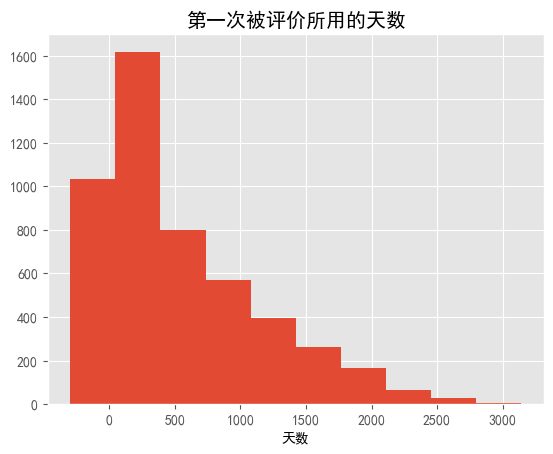

In [70]:
cursorObject.execute(
    '''select min(datediff(lr.first_review,lh.host_since)) as days_to_get_1st_review  
    from listing_review lr 
    inner join listing_host lh on lr.id=lh.id
    group by host_id''')
days_to_get_1st_review = pd.DataFrame(cursorObject.fetchall(), columns=['days_to_get_1st_review'])
days_to_get_1st_review.head()

fig, ax = plt.subplots()
ax.hist(days_to_get_1st_review)
ax.set_title('第一次被评价所用的天数')
ax.set_xlabel('天数')

Step 1.4: Features: listing host

In [96]:
cursorObject = connection.cursor()
cursorObject.execute('''
    SELECT *
    FROM listing_host''')
listing_host = pd.DataFrame(cursorObject.fetchall(),
                                columns=['id','host_id','host_name','host_since','host_location',
                                         'host_about','host_response_time','host_response_rate','host_acceptance_rate',
                                         'host_is_superhost','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic',
                                         'host_identity_verified','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                                         'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'])
listing_host.head()

id  host_id host_name  host_since              host_location  \
0   24963    98203       Jia  2010-03-24  Shanghai, Shanghai, China   
1  479517   681552      Leon  2011-06-09                      China   
2  479530   681552      Leon  2011-06-09                      China   
3  496972  2454164     Alvin  2012-05-24                      China   
4  519944  2131088     Sammy  2012-04-13                      China   

                                          host_about host_response_time  \
0  I am an architect, trained and studied in US, ...                N/A   
1  大家好，我是leon，老家浙江衢州，大学四年在北京，目前住在上海，江湖人称六哥(leon哥的...     within an hour   
2  大家好，我是leon，老家浙江衢州，大学四年在北京，目前住在上海，江湖人称六哥(leon哥的...     within an hour   
3  I'm a Chinese guy living in Shanghai since 200...     within an hour   
4  A very easy going and relaxed person.  I'm fro...                N/A   

  host_response_rate host_acceptance_rate  host_is_superhost  \
0               None                 None                  0   
1               0.01                 1.00                  1   
2               0.01                 1.00                  1   
3               0.01                 0.72                  1   
4               None                 1.00                  1   

  host_neighbourhood  host_listings_count  host_total_listings_count  \
0               音乐学院                    2                          2   
1                 普陀                    4                          4   
2                 普陀                    4                          4   
3                 曲阳                    5                          5   
4                 普陀                    1                          1   

   host_verifications  host_has_profile_pic  host_identity_verified  \
0  ['email', 'phone']                     1                       1   
1  ['email', 'phone']                     1                       1   
2  ['email', 'phone']                     1                       1   
3  ['email', 'phone']                     1                       1   
4  ['email', 'phone']                     1                       1   

   calculated_host_listings_count  \
0                               1   
1                               4   
2                               4   
3                               4   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            4   
2                                            4   
3                                            0   
4                                            0   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             0   
2                                             0   
3                                             3   
4                                             1   

   calculated_host_listings_count_shared_rooms  
0                                            0  
1                                            0  
2                                            0  
3                                            1  
4                                            0

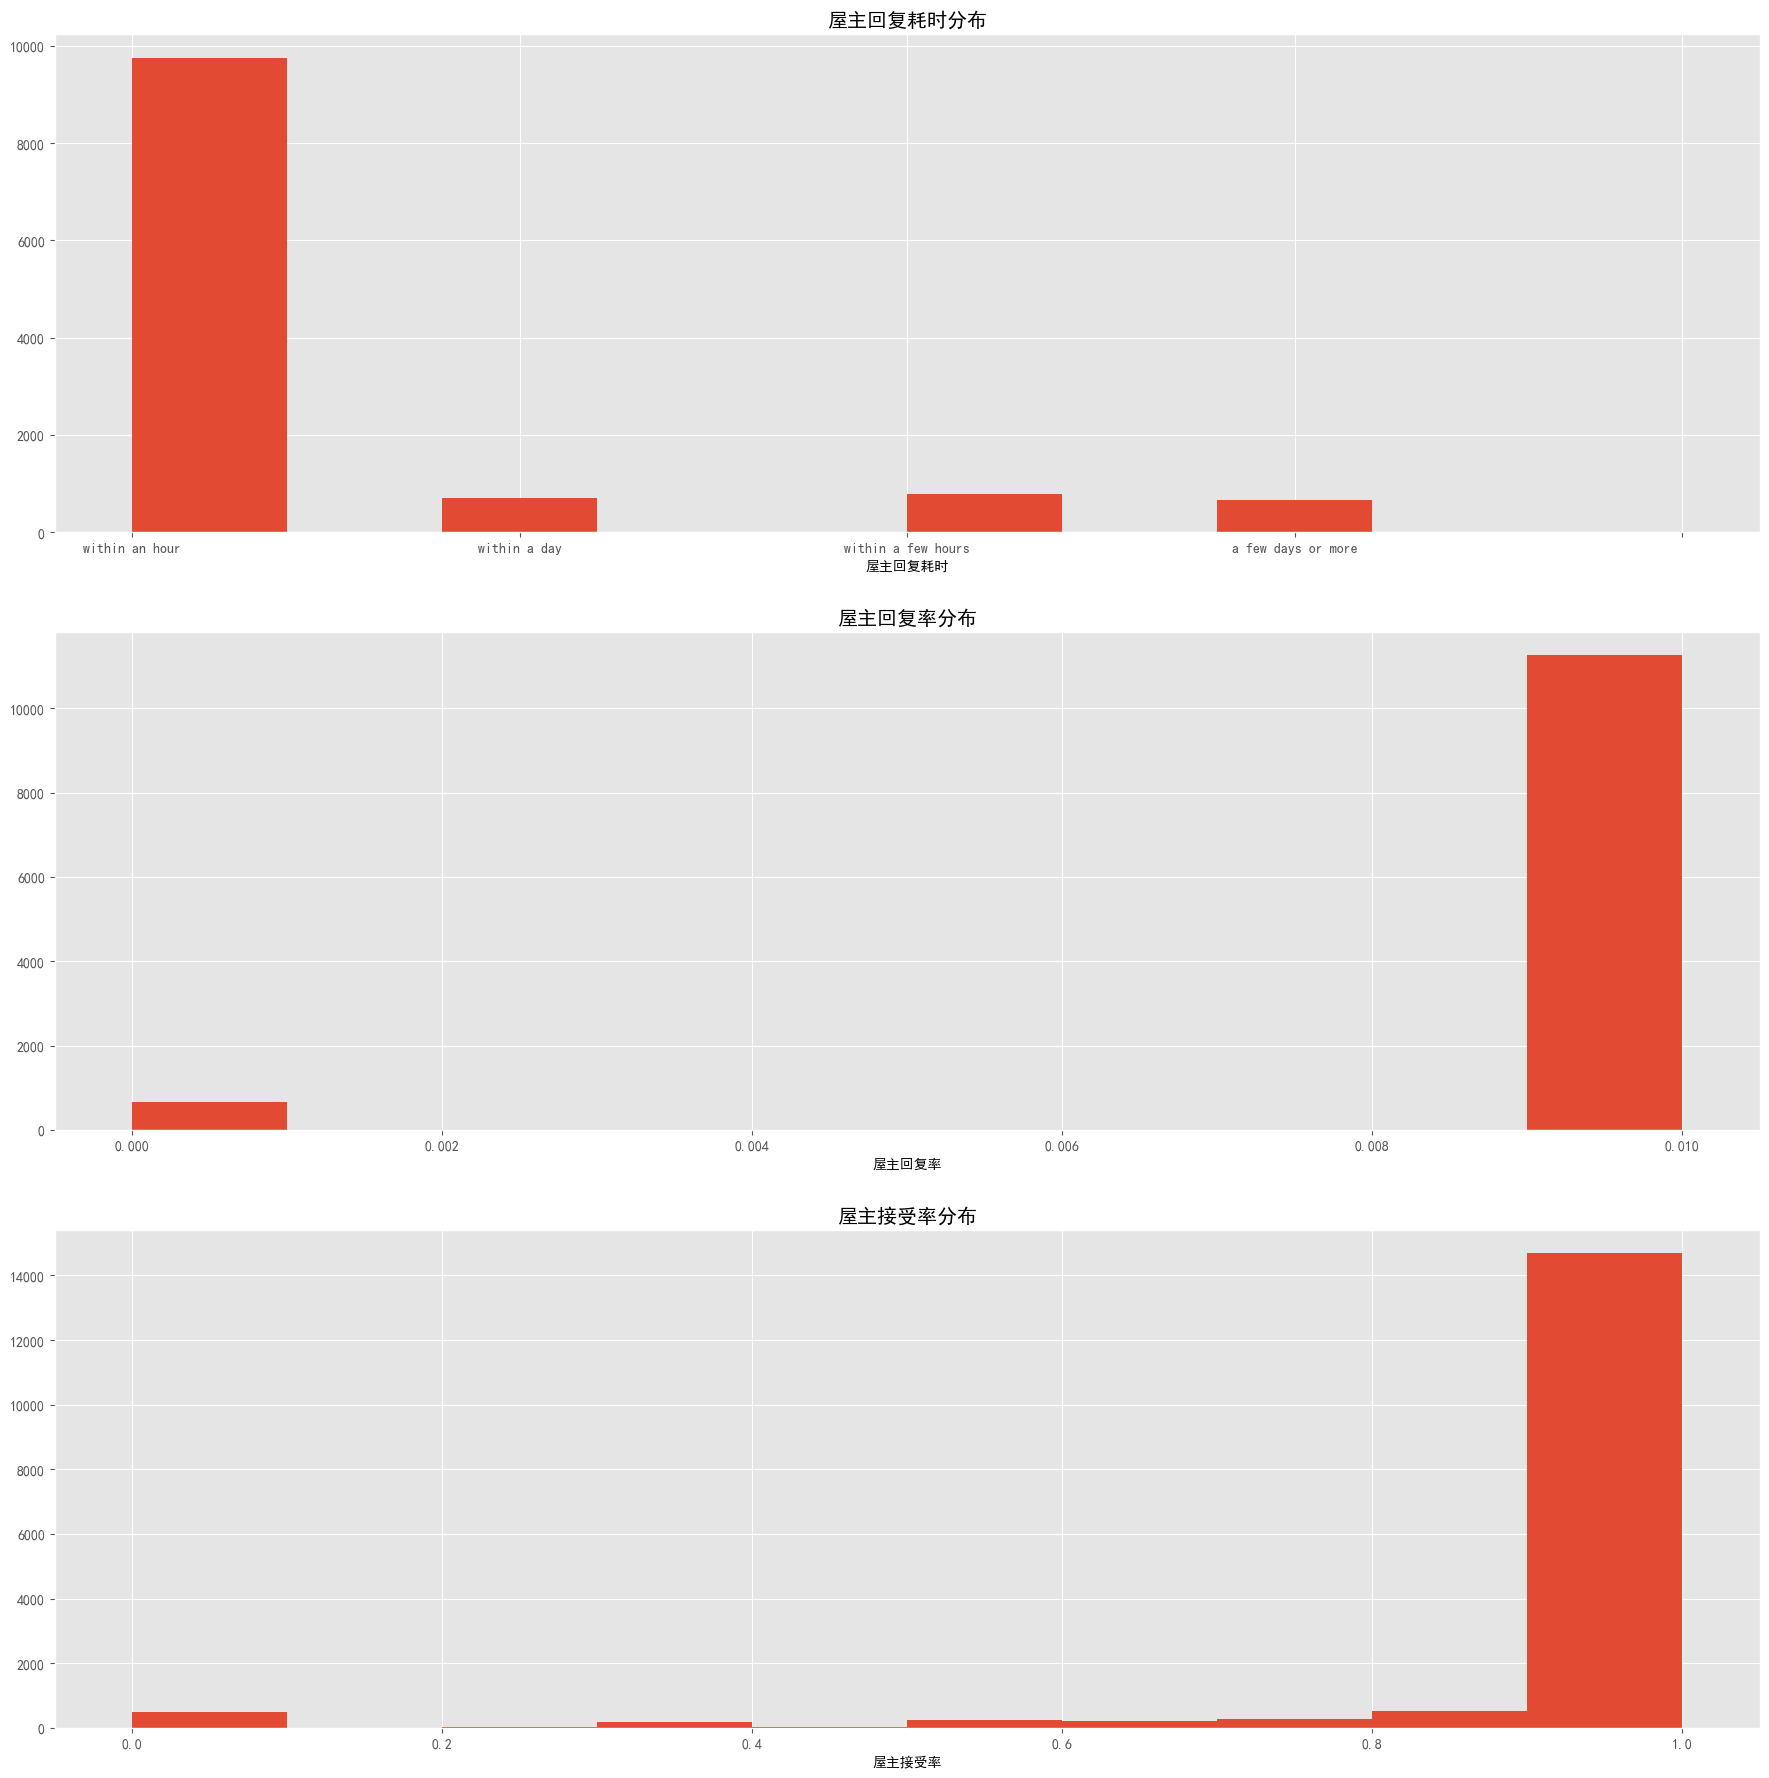

In [97]:
fig, axs = plt.subplots(3,1)
axs[0].hist(listing_host[listing_host['host_response_time'] != 'N/A']['host_response_time'])
axs[0].set_title('屋主回复耗时分布')   
axs[0].set_xlabel(ticker.FixedLocator(['Within an hour','Within a few hours','Within a day','A few days or more']))
axs[0].set_xlabel('屋主回复耗时')
axs[1].hist(listing_host['host_response_rate'])
axs[1].set_title('屋主回复率分布')
axs[1].set_xlabel('屋主回复率')
axs[2].hist(listing_host['host_acceptance_rate'].dropna().sort_values()) 
axs[2].set_title('屋主接受率分布')
axs[2].set_xlabel('屋主接受率')
fig.set_figwidth(22)
fig.set_figheight(22)

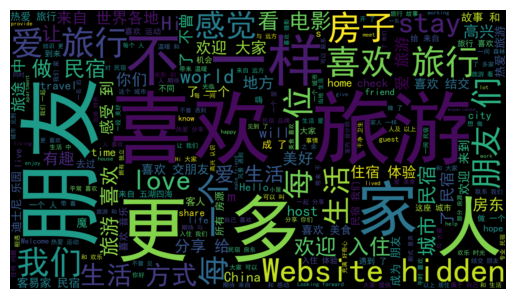

In [43]:
wordcloud(listings['host_about'])

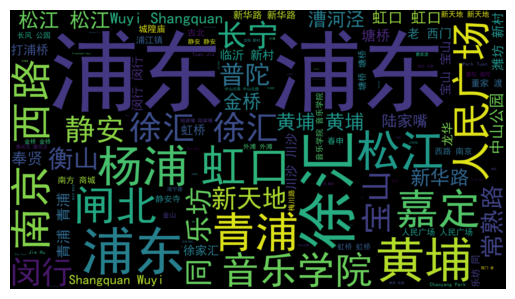

In [44]:
wordcloud(listings['host_neighbourhood'])

Step 1.4 Features: Review

In [45]:
cursorObject = connection.cursor()
cursorObject.execute("SELECT * FROM reviews")
review = pd.DataFrame(cursorObject.fetchall(), columns=['listing_id','id','date','reviewer_id','reviewer_name','comments'])
review.head()

listing_id      id        date  reviewer_id       reviewer_name  \
0       24963  105158  2010-09-26       125515               Lucia   
1       24963  191610  2011-03-03       311924               Marty   
2       24963  347084  2011-07-02        23521              Thomas   
3       24963  384765  2011-07-20       491296               Nikko   
4       24963  406458  2011-07-30       228345  Deborah And Andrew   

                                            comments  
0  Even though the actual apt listed was not read...  
1  Jia's place is in a vibrant and (in my opinion...  
2  The host canceled my reservation the day befor...  
3  JIa and her apt was great!  It was easy to fin...  
4  Clean, spacious apartment in a lovely neighbor...

In [46]:
review.shape

(274768, 6)

In [47]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274768 entries, 0 to 274767
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     274768 non-null  int64 
 1   id             274768 non-null  int64 
 2   date           274768 non-null  object
 3   reviewer_id    274768 non-null  int64 
 4   reviewer_name  274768 non-null  object
 5   comments       274766 non-null  object
dtypes: int64(3), object(3)
memory usage: 12.6+ MB


In [48]:
review.nunique()

listing_id        13668
id               274768
date               2556
reviewer_id      238675
reviewer_name     99376
comments         256088
dtype: int64

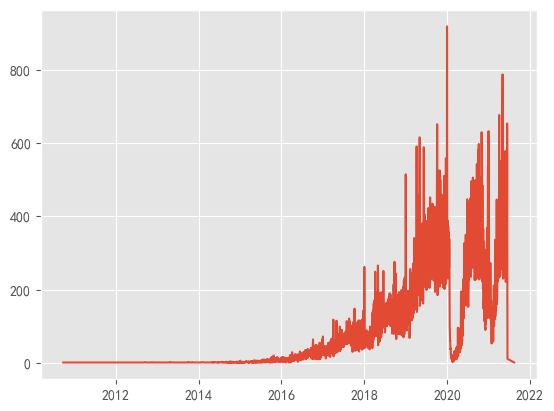

In [49]:
fig,ax = plt.subplots()
ax.plot(review['date'].groupby(review['date']).count())

由于无法得到销售数据，评论日期从一定程度能够体现销售上的变化。从2016年正式进入中国直至2020年的新冠疫情，airbnb上海的评论数量一直处于稳步上升的状态。而疫情后的第一和第三次大跌分别与2020年2月和2022年3月的两次封城相吻合。第二次在2021年3月左右的跌落原因不明。

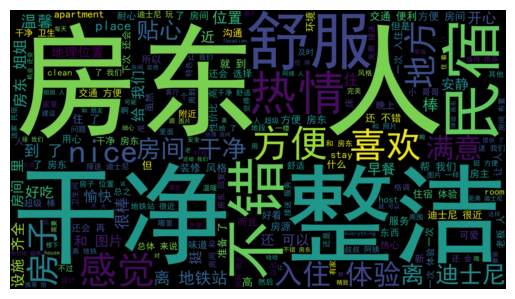

In [50]:
wordcloud(review['comments'])

Step 2：变量间关系

In [63]:
corr_pairs = listings.dropna().corr(numeric_only = True).unstack()
corr_pairs[corr_pairs < 1][(corr_pairs) > 0.3].sort_values(ascending=False)

maximum_nights_avg_ntm                        maximum_maximum_nights                          0.999263
maximum_maximum_nights                        maximum_nights_avg_ntm                          0.999263
minimum_maximum_nights                        maximum_nights_avg_ntm                          0.998704
maximum_nights_avg_ntm                        minimum_maximum_nights                          0.998704
maximum_minimum_nights                        minimum_nights_avg_ntm                          0.996535
minimum_nights_avg_ntm                        maximum_minimum_nights                          0.996535
maximum_maximum_nights                        minimum_maximum_nights                          0.996399
minimum_maximum_nights                        maximum_maximum_nights                          0.996399
minimum_nights_avg_ntm                        minimum_minimum_nights                          0.994728
minimum_minimum_nights                        minimum_nights_avg_ntm     

<AxesSubplot:>

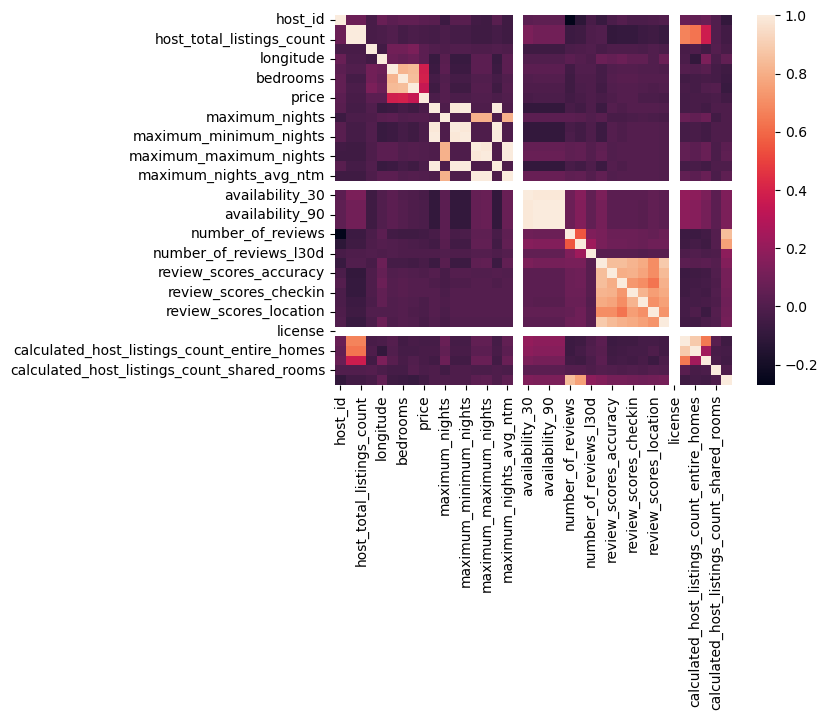

In [ ]:
corr_matrix = listings.corr().round(2)
sb.heatmap(corr_matrix)

Text(0.5, 0, '公开出租时长')

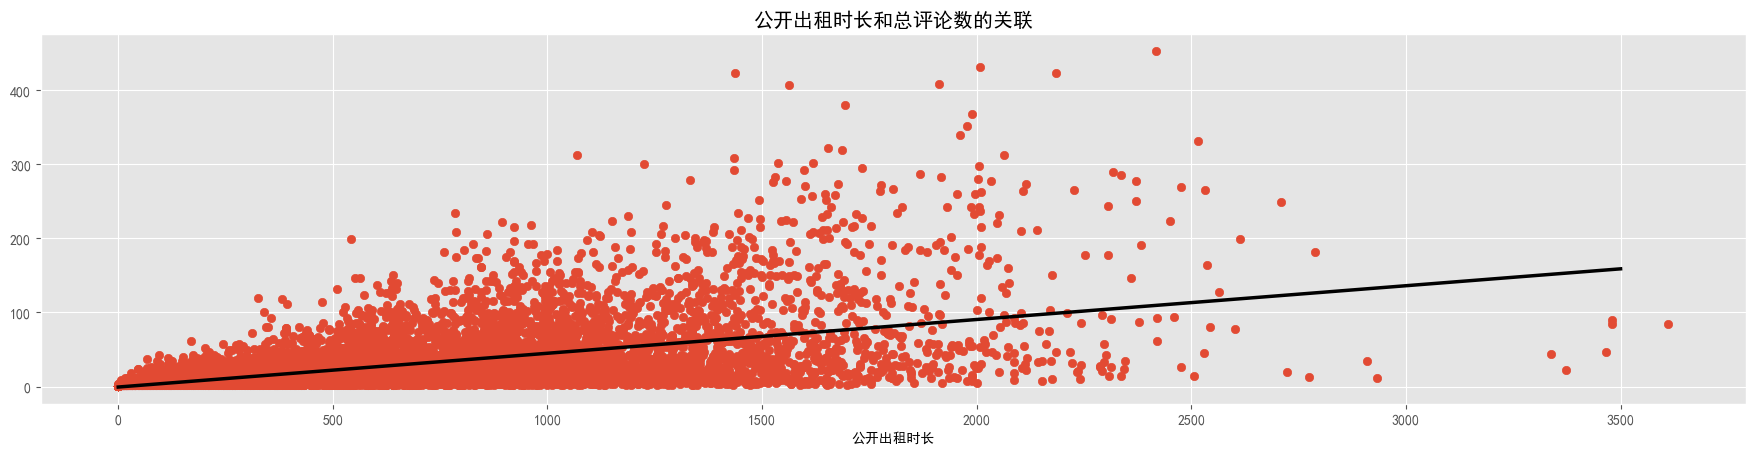

In [84]:
cursorObject.execute(
    '''select datediff(last_review,first_review) as days_listed, number_of_reviews   
    from listing_review''')
days_listed_vs_number_of_reviews = pd.DataFrame(cursorObject.fetchall(), columns=['days_listed', 'number_of_reviews']).dropna()
days_listed_vs_number_of_reviews.head()

fig, ax = plt.subplots()
ax.scatter(days_listed_vs_number_of_reviews['days_listed'],days_listed_vs_number_of_reviews['number_of_reviews'])
b, a = np.polyfit(days_listed_vs_number_of_reviews['days_listed'],days_listed_vs_number_of_reviews['number_of_reviews'], deg=1)
xseq = np.linspace(0, 3500, num=100)
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)
fig.set_figwidth(22)
ax.set_title('公开出租时长和总评论数的关联')
ax.set_xlabel('公开出租时长')

Text(0.5, 0, '区域')

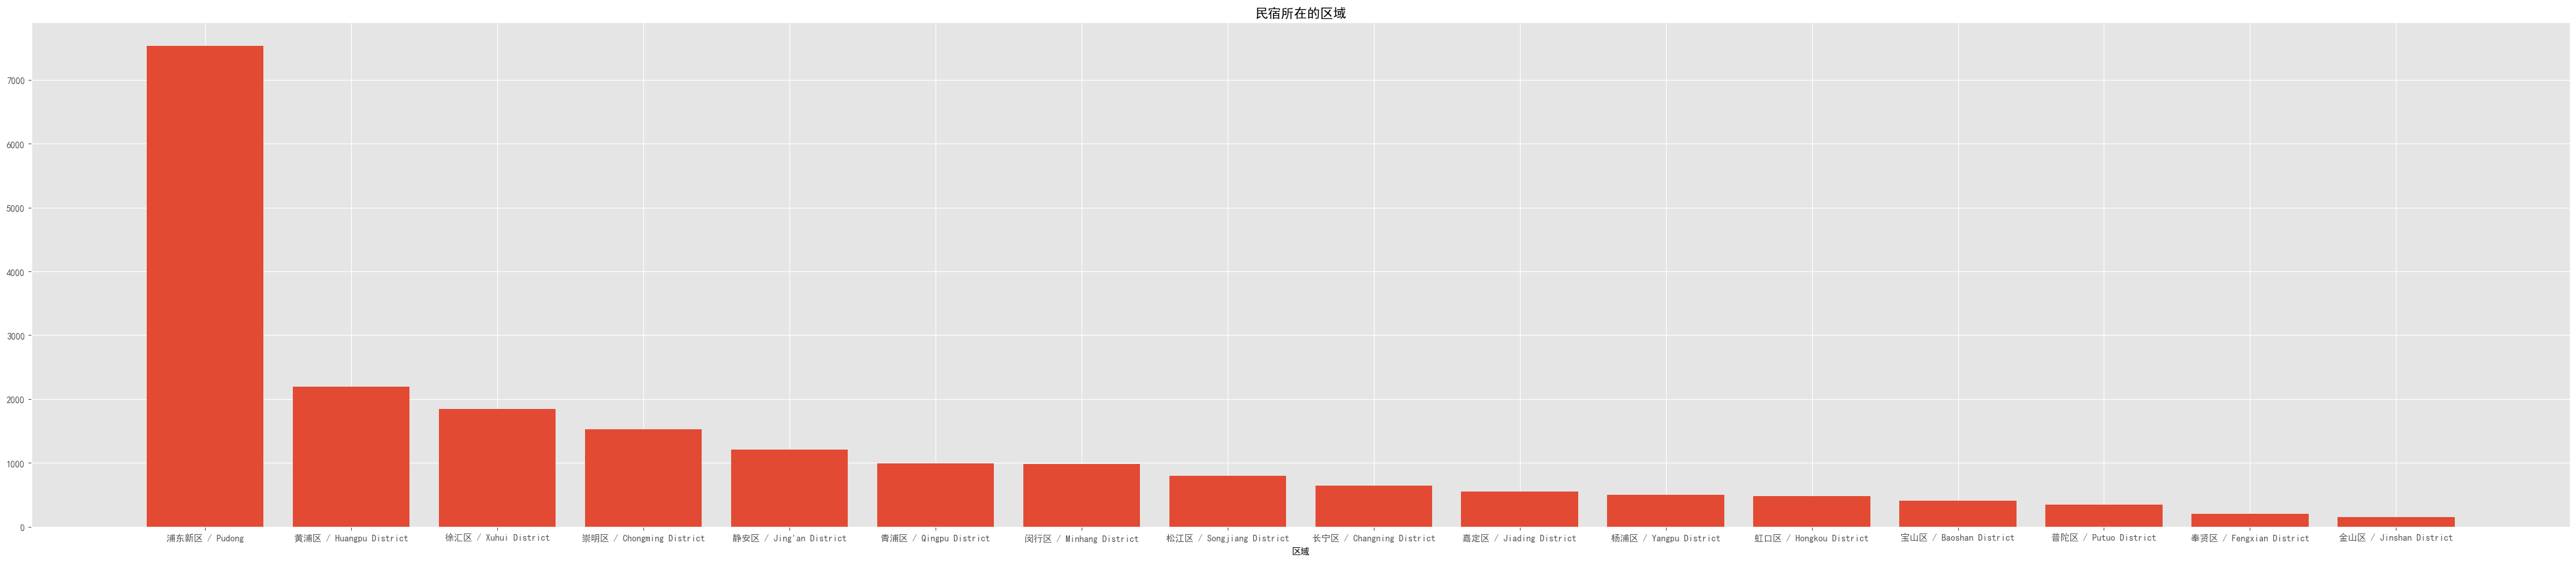

In [86]:
cursorObject = connection.cursor()
cursorObject.execute('''
    select distinct neighbourhood_cleansed, count(*) 
    from listing_property 
    group by neighbourhood_cleansed''')
properties_neighbourhood = pd.DataFrame(cursorObject.fetchall(), columns = ['区域','房屋数'])
properties_neighbourhood = properties_neighbourhood.sort_values(by='房屋数',ascending=False)

fig,ax = plt.subplots()
ax.bar(properties_neighbourhood['区域'],properties_neighbourhood['房屋数'])
fig.set_figwidth(50)
fig.set_figheight(10)
ax.set_title('民宿所在的区域')
ax.set_xlabel('区域')

Text(0.5, 0, '区域')

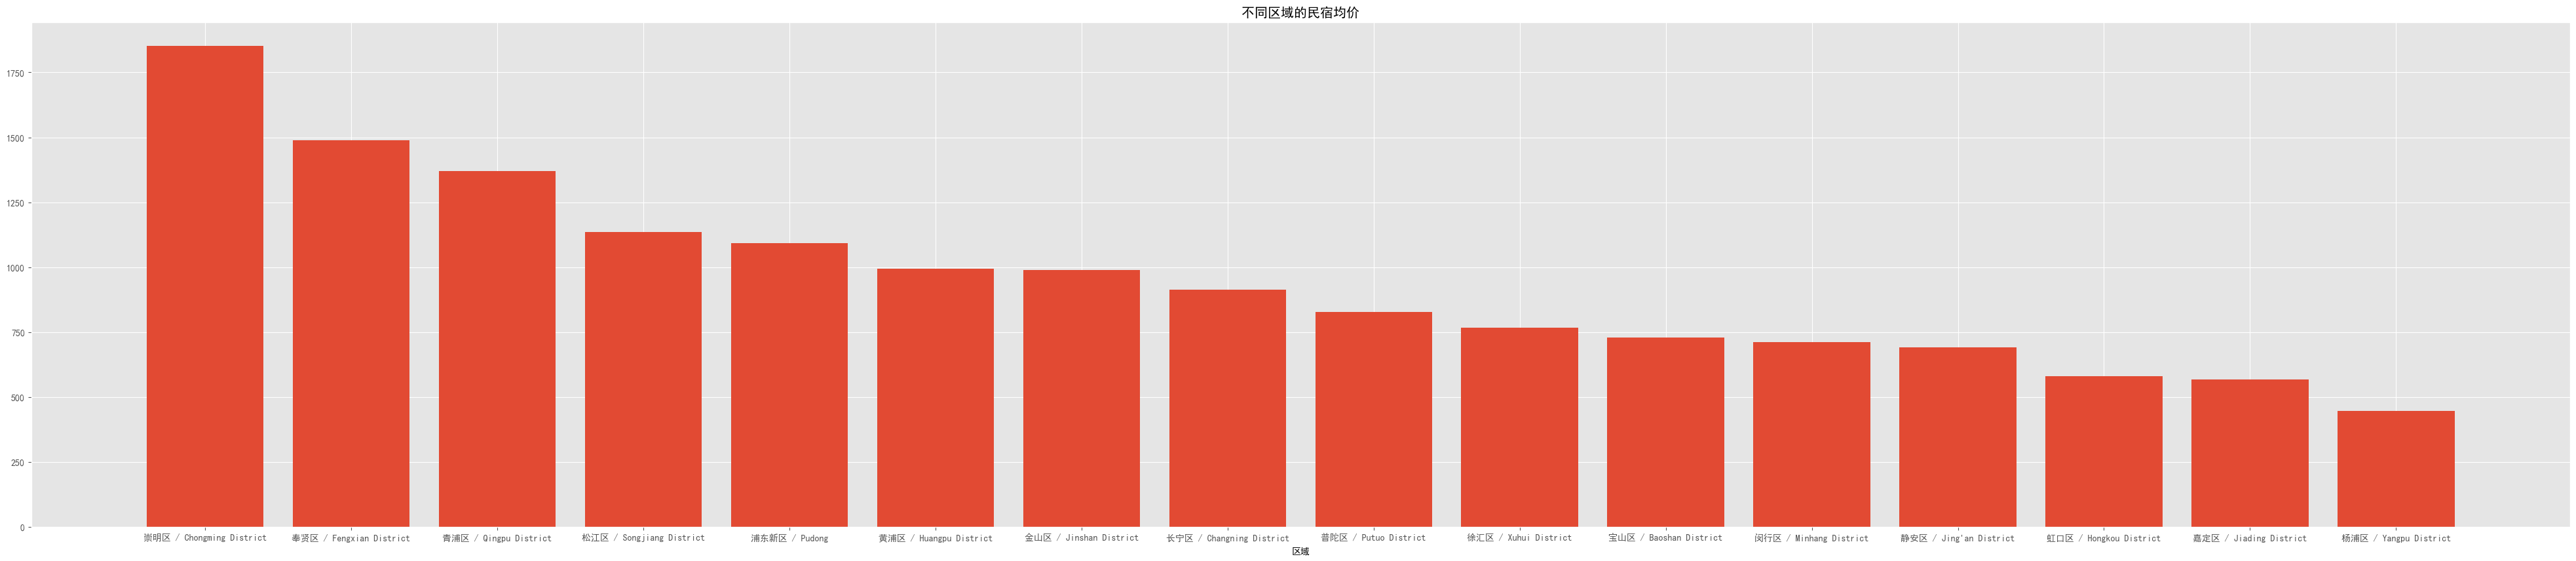

In [87]:
cursorObject = connection.cursor()
cursorObject.execute('''
    select neighbourhood_cleansed, avg(price) 
    from listing_property
    group by neighbourhood_cleansed ''')
price_by_neighbourhood = pd.DataFrame(cursorObject.fetchall(), columns = ['区域','价格'])
price_by_neighbourhood = price_by_neighbourhood.sort_values(by='价格',ascending=False)


fig,ax = plt.subplots()
ax.bar(price_by_neighbourhood['区域'],price_by_neighbourhood['价格'])
fig.set_figwidth(50)
fig.set_figheight(10)
ax.set_title('不同区域的民宿均价')
ax.set_xlabel('区域')

plotly animation date+propertylocati0on
location~price
yuezu~price
super host ~ price
reviews_per_month

Step 3：关闭SQL接口

In [94]:
connection.close()